In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [2]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# Flatten image and remove walls

In [3]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

# max_env_steps = 100

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.
        
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        # self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)
        
        flattened_grid = full_grid.ravel()
        return flattened_grid
    
    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)

In [4]:
def to_coords(state):
    idx = state[0:-1:3]
    n = int(np.sqrt(len(idx)))
    for i in range(n):
        for j in range(n):
            k = n*i + j
            if (idx[k] == 10) or (idx[k] == 8):
                return np.array([i+1, j+1])

class RandomPosAndGoalWrapper(gym.Wrapper):
    
    def reset(self):
        
        
        # Generate goal state
        self.env.unwrapped.agent_pos = np.random.randint(1, self.grid_size-2, 2) 
        # self.env.unwrapped.agent_pos = np.array([self.grid_size-2, self.grid_size-2])
        self.goal_state = self.env.observation(self.env.unwrapped.gen_obs())
        goal_pos = to_coords(self.goal_state)
        
        # Set initial state
        self.env.reset()
#        init_pos = np.array([1, 1])
        init_pos = (goal_pos + np.random.randint(0, self.grid_size-2, 2))%(self.grid_size-2) + 1
        while (init_pos==goal_pos).all():
            init_pos = (goal_pos + np.random.randint(0, self.grid_size-2, 2))%(self.grid_size-2) + 1
            
        self.env.unwrapped.agent_pos = init_pos
        
        # Return initial state 
        return self.env.observation(self.env.unwrapped.gen_obs())
    
    def __init__(self, env):
        self.goal_state = None
        self.grid_size = env.unwrapped.grid.encode().shape[0]
        super().__init__(env)
        
        
    def step(self, action):
        state = self.env.observation(self.env.unwrapped.gen_obs())
        next_state, reward, done, info = self.env.step(action)
        cur_pos, next_pos, goal_pos = to_coords(state), to_coords(next_state), to_coords(self.goal_state)
        dist1 = np.linalg.norm(cur_pos - goal_pos)
        dist2 = np.linalg.norm(next_pos - goal_pos)
        
        reward = (dist1 - dist2)
        reward = 1 - np.sqrt(2) if reward == 0 else reward
        
        if (next_pos == goal_pos).all() or (self.step_count  >= self.max_steps):
            done = True
        else: 
            done = False
        
        return next_state, reward, done, info
    
            
from gym.wrappers import Monitor

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    env = FlatObsWrapper(gym.make(env_name))
    env = RandomPosAndGoalWrapper(env)
    return wrap_env(env)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def run_episode(env, agent, train_mode=True, show_steps=False):
    """
    A hepler function for running single episode
    """
    
    state = env.reset() 
    goal_state = env.goal_state
    if not train_mode:
        agent.expore = False
        print("From ", to_coords(state), "to", to_coords(goal_state))
    score = 0 
    done = False
    
    steps = 0
    while not done:
        steps+=1
        action = agent.act(state, env.goal_state)                           
        next_state, reward, done, _ = env.step(action)
        agent.update(state, env.goal_state, action, reward, next_state, done)
        score += reward                                     
        state = next_state 
            
        if (not train_mode) and show_steps:
            img = env.render('rgb_array')
            plt.imshow(img);
            plt.show()
            
    agent.reset_episode()
    env.close()
    
    if not train_mode:
        show_video()
    
    return score, steps

def run_episodes_and_display(env, agent, n_episodes=1000):
    """
    Runs a series of episode and display agent's performance
    """
    
    display_step = 100
    score = 0
    score_sum = 0
    scores = []
    steps = []
    for episode in range(1, n_episodes+1):
        score, step = run_episode(env, agent, train_mode=True)
        score_sum += score
        scores.append(score)
        steps.append(step)
        if episode%display_step==0:
            avg_score = score_sum/display_step
            print("Episode: {}. Average score: {}".format(episode, avg_score))
            score_sum = 0
            
    fig = plt.figure()
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Max Score')
    plt.xlabel('Episode #')
    plt.show()
    
    fig = plt.figure()
    plt.plot(np.arange(len(steps)), steps)
    plt.ylabel('Steps')
    plt.xlabel('Episode #')
    plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class ActorNetwork(nn.Module):
    """
    Actor is a policy network. Given state it evaluates 
    probability of action given state or sample an action
    """
    def __init__(self, state_size, action_size, emb_size, seed=42, hidden_size1=64, hidden_size2=64):
        super(ActorNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1 + emb_size, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, action_size)
        

    def forward(self, states, embs, actions=None):
        x = F.relu(self.layer1(states))
        x = torch.cat((x, embs), 1)
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        probs = F.softmax(x, dim=1)
        
        action_dist = Categorical(probs)
        actions = actions if actions is not None else action_dist.sample()
        
        action_log_prob = action_dist.log_prob(actions.squeeze())
        entropy = action_dist.entropy()
        
        return actions.detach(), action_log_prob.unsqueeze(1), entropy
    
class CriticNetwork(nn.Module):
    """
    Critic network estimates value function
    """

    def __init__(self, state_size, emb_size, seed=42, hidden_size1=64, hidden_size2=64):
        super(CriticNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1 + emb_size, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, 1)

    def forward(self, states, embs):
        x = F.relu(self.layer1(states))
        x = torch.cat((x, embs), 1)
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    
class NavigatorNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """

    def __init__(self, state_size, emb_size, seed=42, hidden_size1=64):
        super(NavigatorNetwork, self).__init__()
        self.emb_size = emb_size
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, emb_size)

    def forward(self, goal_states):
        x = F.relu(self.layer1(goal_states))
        return F.relu(self.layer2(x))
    
    
class ActorCritic(nn.Module):
    """
    Actor-critic model
    """
    
    def __init__(self, state_size, action_size, emb_size):
        super(ActorCritic, self).__init__()
        self.navigator = NavigatorNetwork(state_size, emb_size)
        self.actor = ActorNetwork(state_size, action_size, emb_size)
        self.critic = CriticNetwork(state_size, emb_size)
        
    def act(self, states, goal_states):
        embs = self.navigator.forward(goal_states)
        actions, _, _ = self.actor.forward(states, embs, None)
        return actions
    
    def evaluate(self, states, goal_states, actions):
        embs = self.navigator.forward(goal_states)
        _, logprobs, entropy = self.actor.forward(states, embs, actions)
        
        values = self.critic.forward(states, embs)
        return values, logprobs, entropy.reshape(-1, 1)
    

class Memory():
    """
    Memory buffer for saving trajectories
    """
    
    def __init__(self):
        self.states = []
        self.goal_states = []
        self.next_states = []
        self.actions = []
        self.rewards = []
        self.dones = []
    
    def clear(self):
        del self.states[:]
        del self.goal_states[:]
        del self.next_states[:]
        del self.actions[:]
        del self.rewards[:]
        del self.dones[:]
        
    def get_trajectory(self):
        to_torch = lambda arr: torch.from_numpy(np.array(arr)).to(device).float()
        actions = to_torch(self.actions)
        states = to_torch(self.states)
        goal_states = to_torch(self.goal_states)
        next_states = to_torch(self.next_states)
        rewards = to_torch(self.rewards).reshape(-1, 1)
        dones = to_torch(self.dones).reshape(-1, 1)
        return states, goal_states, actions, rewards, next_states, dones
    
class PPOAgent():
    
    def __init__(self, state_size, action_size, emb_size, actor_critic=None, T=128, K_epochs=10, lr=5e-3, 
                 lamb=0.8, gamma=0.97, eps=0.2, c1 = 0.5, c2 = 0.01):
        """Initializes agent object
        
        Args:
         action_size - action space dimensions
         state_size - state space dimensions
         actor_critic - pretrained actor-critic network
         T - time steps to collect before agent updating
         K_epochs - number of steps while optimizing networcs
         lr - learning rate for Adam optimizer
         lamb - smoothing parameter for generalized advantage estimator
         gamma - decay
         eps - clipping threshold
         c1 - weight for critic loss
         c2 - weight for entropy loss
         
        """
        self.policy = ActorCritic(state_size, action_size, emb_size).to(device)
        if actor_critic is not None:
            self.policy.load_state_dict(actor_critic.state_dict())
            
        self.policy_old = ActorCritic(state_size, action_size, emb_size).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.memory = Memory()
        self.T = T
        self.K_epochs = K_epochs
        self.c1 = c1
        self.c2 = c2
        self.lamb = lamb
        self.gamma = gamma
        self.epsilon = eps
        self.mse_loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def act(self, states, goal_states):
        """Takes actions given batch of states
        
        Args:
         states - a batch of states
        
        Returns:
         actions - a batch of actions generated given states
        """
        states = torch.from_numpy(np.vstack([states])).float().to(device)
        goal_states = torch.from_numpy(np.vstack([goal_states])).float().to(device)
        with torch.no_grad():
            actions = self.policy_old.act(states, goal_states)
            return actions.detach().cpu().numpy()
        
    def update(self, states, goal_states, actions, rewards, next_states, dones):
        """Updates actor critic network
        
        Args:
         states - states for parallel agents, shape [n_agents x state_size]
         actions - actions for parallel agents, shape [n_agents x action_size]
         rewards - rewards for parallel agents, shape [n_agents x 1]
         next_states - next states for parallel agents, shape [n_agents x state_size]
         dones - edisode finishing flags for parallel agents, shape [n_agents x 1]
         
        """
              
        # Add to memory untill collect trajectories of length memory_size        
        if len(self.memory.states) < self.T:
            self.memory.actions.append(actions)
            self.memory.states.append(states)
            self.memory.goal_states.append(goal_states)
            self.memory.rewards.append(rewards)
            self.memory.next_states.append(next_states)
            self.memory.dones.append(dones)
            return
                
        # Optimize   
        for _ in range(self.K_epochs):
            loss = self._compute_loss()
            self.optimizer.zero_grad()        
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.)
            self.optimizer.step()
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.memory.clear()
    
    def save(self, f):
        """Saves policy network to file
        
        Args:
         f - output file  
        """
        torch.save(self.policy.state_dict(), f)
        

    def _compute_loss(self):
        
        # Iterate over actors and create batch
        loss = 0
            
        states, goal_states, actions, rewards, next_states, dones = self.memory.get_trajectory()
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        rewards_to_go = self._compute_rewards_to_go(rewards, dones)

        values, logprobs, S = self.policy.evaluate(states, goal_states, actions)

        with torch.no_grad():
            values_old, logprobs_old, _ = self.policy_old.evaluate(states, goal_states, actions)
            values_next_old, _, _ = self.policy_old.evaluate(next_states, goal_states, None)
            values_old = values_old.detach()
            values_next_old = values_next_old.detach()
            

        ratios = torch.exp(logprobs - logprobs_old.detach())
        advantages = self._compute_advantages(rewards, values_old, values_next_old, dones)

        # Compute surrogate loss with clipping
        
        s1 = ratios * advantages
        s2 = torch.clamp(ratios, 1 - self.epsilon, 1 + self.epsilon) * advantages
        
        
        L_clip = torch.min(s1, s2)

        # Compute MSE loss for value functions
        
        L_vf = self.mse_loss(values, rewards_to_go)
        
        # Combine losses
        loss += -L_clip.mean() + self.c1*L_vf - self.c2*S.mean()
        
            
        return loss
    
    def _compute_advantages(self, rewards, values, next_values, dones):
        td_errors = rewards + self.gamma*next_values*(1-dones) - values
        A, advantages = 0, []
        for t in reversed(range(len(td_errors))):
            A = td_errors[t] + (self.lamb * self.gamma)*A*(1-dones[t])
            advantages.insert(0, A)
        return torch.from_numpy(np.array(advantages)).float().reshape(-1, 1).to(device)
        
 
    def _compute_rewards_to_go(self, rewards, dones):
        rewards_to_go = []
        R = 0
        for reward, done in zip(reversed(rewards), reversed(dones)):
            R = reward + self.gamma * R * (1-done)
            rewards_to_go.insert(0, R)
        return torch.from_numpy(np.array(rewards_to_go)).float().reshape(-1, 1).to(device)
    
    
    def reset_episode(self):
        return True

cpu


Episode: 100. Average score: -24.279196979533143
Episode: 200. Average score: -18.33374113356964
Episode: 300. Average score: -13.065605441169742
Episode: 400. Average score: -14.535289926045534
Episode: 500. Average score: -11.9001814935033
Episode: 600. Average score: -7.079112027125913
Episode: 700. Average score: -5.13245369086726
Episode: 800. Average score: -6.03475108001042
Episode: 900. Average score: -3.7471302972312492
Episode: 1000. Average score: -2.3511152452877253
Episode: 1100. Average score: -3.1230081228609894
Episode: 1200. Average score: -4.02119314607708
Episode: 1300. Average score: -1.8379774901141688
Episode: 1400. Average score: -2.4212647485866174
Episode: 1500. Average score: -4.920048299978269
Episode: 1600. Average score: -5.032383133172184
Episode: 1700. Average score: -3.884265122092346
Episode: 1800. Average score: -0.8795428021343666
Episode: 1900. Average score: -2.212603546935133
Episode: 2000. Average score: -1.8087343101766304
Episode: 2100. Average 

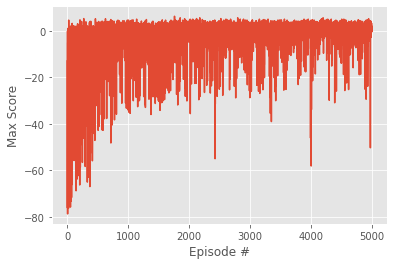

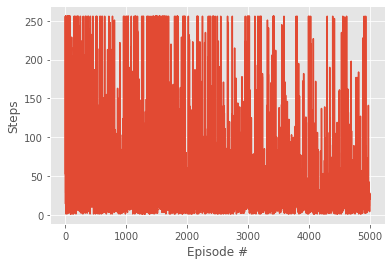

In [7]:
## %%time
env_name = 'MiniGrid-Empty-8x8-v0'
env = gen_wrapped_env(env_name)
state_size = env.observation_space.shape[0]
action_size = 3
agent = PPOAgent(state_size, action_size, emb_size=64,
                 T=512, # 512
                 K_epochs=10, # 10
                 lr=5e-4, # 5e-4
                 gamma=0.97, # 0.99
                 lamb=0.8, # 0.99
                 eps=0.2, 
                 c1=0.5, 
                 c2=0.01)
run_episodes_and_display(env, agent, n_episodes=5000)

In [8]:
env = gen_wrapped_env(env_name)
run_episode(env, agent, train_mode=False, show_steps=False)

From  [1 2] to [4 2]


(3.0, 3)